In [1]:
from googlenet_lite import create_model
from keras import optimizers

input_shape = (28,28,3)
classes = 2

optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
GoogLeNet = create_model(input_shape=input_shape, classes=classes)
# loss_weights - weighting losses of main classifier and auxiliary classifiers
GoogLeNet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = ['accuracy'], loss_weights=[1., 0.3, 0.3])


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [2]:
import numpy as np

X = np.load('X.npy')
y = np.load('y.npy')

train_index =[8,9,10,11]
test_index = [12,13]

X_train, X_test = X[train_index].reshape((X.shape[1]*4, 28, 28, 3)), X[test_index].reshape((y.shape[1]*2, 28, 28, 3))
y_train, y_test = y[train_index].reshape((X.shape[1]*4, 2)), y[test_index].reshape((y.shape[1]*2, 2))
        
GoogLeNet.fit(X_train, [y_train, y_train, y_train], epochs=15,
                            batch_size=50,
                            validation_data=(X_test, [y_test, y_test, y_test]),
                            verbose=1)


Train on 1592 samples, validate on 796 samples
Epoch 1/15
1592/1592 [==============================] - 52s 33ms/step - loss: 3.1068 - dense_5_loss: 0.8152 - dense_2_loss: 0.8573 - dense_4_loss: 0.7580 - dense_5_accuracy: 0.4950 - dense_2_accuracy: 0.5151 - dense_4_accuracy: 0.4906 - val_loss: 2.5779 - val_dense_5_loss: 0.6931 - val_dense_2_loss: 0.6935 - val_dense_4_loss: 0.6934 - val_dense_5_accuracy: 0.5000 - val_dense_2_accuracy: 0.5000 - val_dense_4_accuracy: 0.5000
Epoch 2/15
1592/1592 [==============================] - 20s 13ms/step - loss: 2.4075 - dense_5_loss: 0.6933 - dense_2_loss: 0.6737 - dense_4_loss: 0.6929 - dense_5_accuracy: 0.5075 - dense_2_accuracy: 0.5559 - dense_4_accuracy: 0.5226 - val_loss: 2.2749 - val_dense_5_loss: 0.6932 - val_dense_2_loss: 0.6942 - val_dense_4_loss: 0.6932 - val_dense_5_accuracy: 0.5000 - val_dense_2_accuracy: 0.5226 - val_dense_4_accuracy: 0.5000
Epoch 3/15
1592/1592 [==============================] - 20s 13ms/step - loss: 2.1687 - dense_5_l

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt
from eeg_learn_functions import gen_images
%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
batch_size = 32
num_classes = 2
epochs = 300
def get_model(input_shape = (28, 28, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

Using TensorFlow backend.


## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [3]:
delta = (0.1, 4)
theta = (4,8)
alpha = (8,14)
beta = (14,30)
gamma = (30, 50)

In [4]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [5]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,30)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [6]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128.0
    i = 0
    intervals = []
    samples_per_frame = 100#Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [7]:
def smooth(x):
    new = []
    for i in range(x.shape[0]):
        if(i == 0):
            new.append((x[i]+x[i+1])/2)
        elif(i == x.shape[0]-1):
            new.append((x[i]+x[i-1])/2)
        else:
            new.append((x[i-1]+x[i]+x[i+1])/3)
    return np.array(new)

In [8]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = 100#Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [9]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [10]:
from sklearn.preprocessing import StandardScaler
import pickle
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap, normalize = False):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = 100#Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',')
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
    print(X.shape)
    if(normalize):
        X_r = X[:,:,:,0].reshape((X.shape[0]*image_size, image_size))
        X_g = X[:,:,:,1].reshape((X.shape[0]*image_size, image_size))
        X_b = X[:,:,:,2].reshape((X.shape[0]*image_size, image_size))

        X[:,:,:,0] = scale(X_r, axis = 1).reshape((X.shape[0], X.shape[1], X.shape[2])) 
        X[:,:,:,1] = scale(X_g, axis = 1).reshape((X.shape[0], X.shape[1], X.shape[2])) 
        X[:,:,:,2] = scale(X_b, axis = 1).reshape((X.shape[0], X.shape[1], X.shape[2])) 
    
        #with open('scalers_dump.pickle', 'wb') as f:
        #    pickle.dump(scalers, f)
    return X,np.array(y)

In [11]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [32]:
from sklearn.model_selection import KFold
import keras
image_size = 28
frame_duration = 0.78
overlap = 0.8
num_classes = 2

file_names = ['data/data_train_new_appr_1_label1.csv',
              'data/data_train_new_appr_2_label0.csv',
              'data/data_train_new_appr_3_label1.csv',
              'data/data_train_new_appr_4_label0.csv',
              'data/data_train_new_appr_6_label1.csv',
              'data/data_train_new_appr_5_label0.csv',
              'data/data_train_new_appr_8_label1.csv',
              'data/data_train_new_appr_7_label0.csv',
              'data/data_train_new_appr_10_label1.csv',
              'data/data_train_new_appr_9_label0.csv',
              'data/data_train_new_appr_12_label1.csv',
              'data/data_train_new_appr_11_label0.csv',
              'data/data_train_new_appr_14_label1.csv',
              'data/data_train_new_appr_13_label0.csv',
              'data/data_train_new_appr_15_label1.csv',
              'data/data_train_new_appr_16_label0.csv',
              'data/data_train_new_appr_17_label1.csv',
              'data/data_train_new_appr_18_label0.csv',
              'data/data_train_new_appr_19_label1.csv',
              'data/data_train_new_appr_20_label0.csv'
              ]
file_names_good = ['data/data_train_new_appr_10_label1.csv',
              'data/data_train_new_appr_9_label0.csv',
              'data/data_train_new_appr_12_label1.csv',
              'data/data_train_new_appr_11_label0.csv',
              'data/data_train_new_appr_14_label1.csv',
              'data/data_train_new_appr_13_label0.csv',
              'data/data_train_new_appr_21_label1.csv',
              'data/data_train_new_appr_22_label0.csv', 
              'data/data_train_new_appr_23_label1.csv',
              'data/data_train_new_appr_24_label0.csv' ]
labels = [1,0,1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,  1, 0, 1, 0]
labels_good = [1,0,1,0,1,0,1,0,1,0,1,0]
X_transformed_list = []
y_transformed_list = []
for f_name, lbl in zip(file_names_good, labels_good):
    X, y = make_data_pipeline([f_name],[lbl],image_size,frame_duration,overlap, normalize = True)
    X = X.astype('float32')
    y = keras.utils.to_categorical(y, num_classes)
    X_transformed_list.append(X)
    y_transformed_list.append(y)



Generating training data...
Processing session:  data/data_train_new_appr_10_label1.csv . ( 1  of  1 )
995erpolating 995/995nterpolating 67/995Interpolating 101/995Interpolating 174/995Interpolating 208/995Interpolating 236/995Interpolating 272/995Interpolating 339/995Interpolating 376/995Interpolating 441/995Interpolating 474/995Interpolating 509/995Interpolating 545/995Interpolating 582/995Interpolating 615/995Interpolating 651/995Interpolating 689/995Interpolating 722/995Interpolating 754/995Interpolating 790/995Interpolating 827/995Interpolating 859/995Interpolating 895/995Interpolating 932/995Interpolating 968/995  frames generated with label  1 .


(995, 28, 28, 3)
Generating training data...
Processing session:  data/data_train_new_appr_9_label0.csv . ( 1  of  1 )
995  frames generated with label  0 .995Interpolating 104/995Interpolating 140/995Interpolating 209/995Interpolating 244/995Interpolating 281/995Interpolating 317/995Interpolating 346/995Interpolating 381/995Interpolat

In [33]:
X_transformed_list_np = np.array(X_transformed_list)
y_transformed_list_np = np.array(y_transformed_list)
X_transformed_list_np.shape

(10, 995, 28, 28, 3)

In [20]:
import tensorflow as tf  # hinge nice
from keras import backend as K
import sklearn
from sklearn.model_selection import KFold
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
from sklearn.metrics import classification_report
batch_size =32 
epochs = 50
scores_list = {}
reports = []
kf = KFold(n_splits=6)
tx = X_transformed_list_np#[bads]
ty = y_transformed_list_np#[bads]
for train_index, test_index in kf.split(tx):
    print("TRAIN:", train_index, "TEST:", test_index)
    if(test_index[0]>=0):
        X_train, X_test = tx[train_index].reshape((tx.shape[1]*10, 28, 28, 3)), tx[test_index].reshape((tx.shape[1]*2, 28, 28, 3))
        y_train, y_test = ty[train_index].reshape((ty.shape[1]*10, 2)), ty[test_index].reshape((ty.shape[1]*2, 2))
        model = get_model()
        opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
        
        # Let's train the model using RMSprop
        model.compile(loss='categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy',tf.keras.metrics.AUC()])

        #x_train = x_train.astype('float32')
        #x_test = x_test.astype('float32')
        #x_train /= 255
        #x_test /= 255


        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data = (X_test, y_test), verbose = 1, shuffle = True)
        #scores_list[str(test_index[0])+"_"+str(test_index[1])] = model.evaluate(X_test, y_test)
        scores_list[str(test_index[0])] = model.evaluate(X_test, y_test)
        report = classification_report(y_test[:,1],   model.predict(X_test).argmax(axis = -1), target_names=['1', '0'])
        reports.append(report)


[]
for i in reports:
    print(i)
    print("\n############################\n")

TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [0 1]
Train on 9950 samples, validate on 1990 samples
Epoch 1/50
9950/9950 [==============================] - 8s 832us/step - loss: 0.6846 - accuracy: 0.5643 - auc_2: 0.5534 - val_loss: 0.6653 - val_accuracy: 0.6251 - val_auc_2: 0.6122
Epoch 2/50
9950/9950 [==============================] - 8s 815us/step - loss: 0.6696 - accuracy: 0.6159 - auc_2: 0.6139 - val_loss: 0.6497 - val_accuracy: 0.6472 - val_auc_2: 0.6369
Epoch 3/50
9950/9950 [==============================] - 8s 808us/step - loss: 0.6568 - accuracy: 0.6302 - auc_2: 0.6400 - val_loss: 0.6341 - val_accuracy: 0.6839 - val_auc_2: 0.6497
Epoch 4/50
9950/9950 [==============================] - 8s 808us/step - loss: 0.6470 - accuracy: 0.6460 - auc_2: 0.6578 - val_loss: 0.6314 - val_accuracy: 0.6668 - val_auc_2: 0.6620
Epoch 5/50
9950/9950 [==============================] - 8s 808us/step - loss: 0.6387 - accuracy: 0.6517 - auc_2: 0.6697 - val_loss: 0.6295 - val_accuracy: 0.6714 - val_auc_2

9950/9950 [==============================] - 8s 809us/step - loss: 0.5637 - accuracy: 0.7091 - auc_3: 0.7362 - val_loss: 0.5698 - val_accuracy: 0.7030 - val_auc_3: 0.7368
Epoch 40/50
9950/9950 [==============================] - 8s 808us/step - loss: 0.5626 - accuracy: 0.7124 - auc_3: 0.7375 - val_loss: 0.5709 - val_accuracy: 0.7106 - val_auc_3: 0.7381
Epoch 41/50
9950/9950 [==============================] - 8s 810us/step - loss: 0.5610 - accuracy: 0.7093 - auc_3: 0.7387 - val_loss: 0.5706 - val_accuracy: 0.6995 - val_auc_3: 0.7392
Epoch 42/50
9950/9950 [==============================] - 8s 809us/step - loss: 0.5586 - accuracy: 0.7149 - auc_3: 0.7400 - val_loss: 0.5712 - val_accuracy: 0.7136 - val_auc_3: 0.7406
Epoch 43/50
9950/9950 [==============================] - 8s 809us/step - loss: 0.5571 - accuracy: 0.7163 - auc_3: 0.7411 - val_loss: 0.5759 - val_accuracy: 0.6864 - val_auc_3: 0.7415
Epoch 44/50
9950/9950 [==============================] - 8s 809us/step - loss: 0.5558 - accuracy:

Epoch 33/50
9950/9950 [==============================] - 8s 809us/step - loss: 0.5329 - accuracy: 0.7377 - auc_4: 0.7369 - val_loss: 0.7107 - val_accuracy: 0.5628 - val_auc_4: 0.7374
Epoch 34/50
9950/9950 [==============================] - 8s 811us/step - loss: 0.5320 - accuracy: 0.7368 - auc_4: 0.7384 - val_loss: 0.7225 - val_accuracy: 0.5518 - val_auc_4: 0.7386
Epoch 35/50
9950/9950 [==============================] - 8s 811us/step - loss: 0.5302 - accuracy: 0.7356 - auc_4: 0.7395 - val_loss: 0.7523 - val_accuracy: 0.5432 - val_auc_4: 0.7397
Epoch 36/50
9950/9950 [==============================] - 8s 811us/step - loss: 0.5285 - accuracy: 0.7396 - auc_4: 0.7407 - val_loss: 0.7419 - val_accuracy: 0.5482 - val_auc_4: 0.7409
Epoch 37/50
9950/9950 [==============================] - 8s 811us/step - loss: 0.5264 - accuracy: 0.7384 - auc_4: 0.7418 - val_loss: 0.7367 - val_accuracy: 0.5482 - val_auc_4: 0.7421
Epoch 38/50
9950/9950 [==============================] - 8s 811us/step - loss: 0.5252

Epoch 27/50
9950/9950 [==============================] - 8s 813us/step - loss: 0.5783 - accuracy: 0.7043 - auc_5: 0.7194 - val_loss: 0.6587 - val_accuracy: 0.6407 - val_auc_5: 0.7200
Epoch 28/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5766 - accuracy: 0.7033 - auc_5: 0.7207 - val_loss: 0.6607 - val_accuracy: 0.6327 - val_auc_5: 0.7213
Epoch 29/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5747 - accuracy: 0.7025 - auc_5: 0.7221 - val_loss: 0.6604 - val_accuracy: 0.6548 - val_auc_5: 0.7229
Epoch 30/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5727 - accuracy: 0.7048 - auc_5: 0.7234 - val_loss: 0.6595 - val_accuracy: 0.6628 - val_auc_5: 0.7241
Epoch 31/50
9950/9950 [==============================] - 8s 815us/step - loss: 0.5707 - accuracy: 0.7062 - auc_5: 0.7247 - val_loss: 0.6620 - val_accuracy: 0.6568 - val_auc_5: 0.7255
Epoch 32/50
9950/9950 [==============================] - 8s 817us/step - loss: 0.5701

Epoch 21/50
9950/9950 [==============================] - 8s 811us/step - loss: 0.5804 - accuracy: 0.6987 - auc_6: 0.7260 - val_loss: 0.6022 - val_accuracy: 0.6764 - val_auc_6: 0.7269
Epoch 22/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5790 - accuracy: 0.7001 - auc_6: 0.7278 - val_loss: 0.6037 - val_accuracy: 0.6804 - val_auc_6: 0.7288
Epoch 23/50
9950/9950 [==============================] - 8s 811us/step - loss: 0.5762 - accuracy: 0.7039 - auc_6: 0.7297 - val_loss: 0.6170 - val_accuracy: 0.6995 - val_auc_6: 0.7309
Epoch 24/50
9950/9950 [==============================] - 8s 810us/step - loss: 0.5734 - accuracy: 0.7053 - auc_6: 0.7314 - val_loss: 0.6115 - val_accuracy: 0.7005 - val_auc_6: 0.7325
Epoch 25/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5724 - accuracy: 0.7049 - auc_6: 0.7331 - val_loss: 0.6028 - val_accuracy: 0.6809 - val_auc_6: 0.7339
Epoch 26/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5707

Epoch 15/50
9950/9950 [==============================] - 8s 813us/step - loss: 0.5999 - accuracy: 0.6818 - auc_7: 0.7064 - val_loss: 0.6362 - val_accuracy: 0.6442 - val_auc_7: 0.7085
Epoch 16/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5979 - accuracy: 0.6855 - auc_7: 0.7086 - val_loss: 0.6292 - val_accuracy: 0.6518 - val_auc_7: 0.7105
Epoch 17/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5957 - accuracy: 0.6856 - auc_7: 0.7107 - val_loss: 0.6270 - val_accuracy: 0.6492 - val_auc_7: 0.7125
Epoch 18/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5940 - accuracy: 0.6865 - auc_7: 0.7127 - val_loss: 0.6322 - val_accuracy: 0.6442 - val_auc_7: 0.7144
Epoch 19/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5913 - accuracy: 0.6925 - auc_7: 0.7145 - val_loss: 0.6033 - val_accuracy: 0.6849 - val_auc_7: 0.7159
Epoch 20/50
9950/9950 [==============================] - 8s 812us/step - loss: 0.5893

In [28]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [40]:
#model.predict(X_test)
goods = [0,1, 2,3, 8,9, 10,11, 12,13]
bads = [4,5, 6,7, 14,15,16, 17,18,19]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


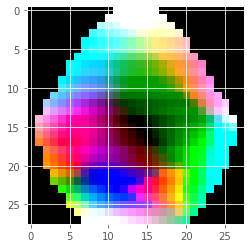

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[202]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


''

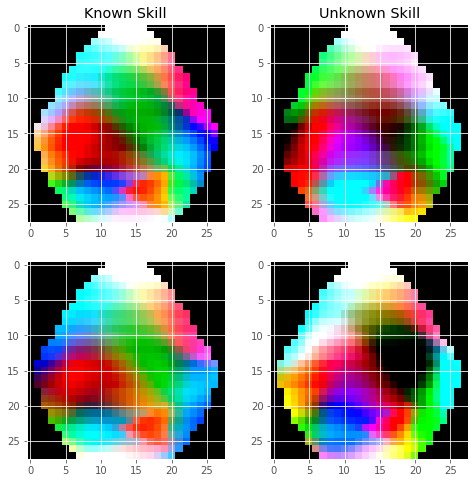

In [71]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title('Known Skill')
axarr[0][0].imshow(X[0])
axarr[1][0].imshow(X[1])

axarr[0][1].set_title('Unknown Skill')
axarr[0][1].imshow(X[1550])
axarr[1][1].imshow(X[1551])

;

In [72]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.01,shuffle=True)

In [74]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
X_test = X_test.astype('float32')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (7880, 28, 28, 3)
7880 train samples
80 test samples


In [24]:
ty.shape
tx.shape

(12, 995, 28, 28, 3)

In [34]:
from sklearn.model_selection import train_test_split
epochs = 50
X = tx[:].reshape((tx.shape[1]*tx.shape[0], 28, 28, 3))
y = ty[:].reshape((ty.shape[1]*ty.shape[0], 2))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05,shuffle=True)

model = get_model()
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255


model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data = (x_test, y_test), verbose = 1, shuffle = True)
#scores_list[str(test_index[0])+"_"+str(test_index[1])] = model.evaluate(X_test, y_test)
#scores_list[str(test_index[0])] = model.evaluate(X_test, y_test)
report = classification_report(y_test[:,1],   model.predict(X_test).argmax(axis = -1), target_names=['1', '0'])
print(report)

model.save('80_model.h5')

Train on 11343 samples, validate on 597 samples
Epoch 1/50
11343/11343 [==============================] - 9s 819us/step - loss: 0.6695 - accuracy: 0.5941 - val_loss: 0.6517 - val_accuracy: 0.6415
Epoch 2/50
11343/11343 [==============================] - 9s 774us/step - loss: 0.6462 - accuracy: 0.6364 - val_loss: 0.6365 - val_accuracy: 0.6566
Epoch 3/50
11343/11343 [==============================] - 9s 777us/step - loss: 0.6351 - accuracy: 0.6497 - val_loss: 0.6265 - val_accuracy: 0.6499
Epoch 4/50
11343/11343 [==============================] - 9s 775us/step - loss: 0.6278 - accuracy: 0.6574 - val_loss: 0.6254 - val_accuracy: 0.6583
Epoch 5/50
11343/11343 [==============================] - 9s 787us/step - loss: 0.6227 - accuracy: 0.6606 - val_loss: 0.6163 - val_accuracy: 0.6683
Epoch 6/50
11343/11343 [==============================] - 9s 777us/step - loss: 0.6184 - accuracy: 0.6654 - val_loss: 0.6076 - val_accuracy: 0.6784
Epoch 7/50
11343/11343 [==============================] - 9s 776

ValueError: Found input variables with inconsistent numbers of samples: [597, 1990]

In [35]:
report = classification_report(y_test[:,1],   model.predict(x_test).argmax(axis = -1), target_names=['1', '0'])
print(report)

model.save('80_model.h5')

              precision    recall  f1-score   support

           1       0.79      0.65      0.71       298
           0       0.70      0.83      0.76       299

    accuracy                           0.74       597
   macro avg       0.75      0.74      0.74       597
weighted avg       0.75      0.74      0.74       597



In [19]:
model.save('path_to_my_model.h5')

In [57]:
model.evaluate(x_test, y_test)

24/24 [==============================] - 0s 250us/step


[0.7046559453010559, 0.625]

In [24]:
from test_pipeline_3 import  TestPipelineEEG
import pandas as pd
import pickle
import keras
import numpy as np
model = keras.models.load_model("80_model.h5")
              #'data/data_train_new_appr_27_label1.csv',
              #'data/data_train_new_appr_28_label0.csv'
predictor = TestPipelineEEG(image_size = 28, frame_duration = 0.78, overlap = 0.0, model_path = '80_model.h5', normalize = True)
data = pd.read_csv('data/data_train_new_appr_28_label0.csv')
data.columns = range(14)
overlap = 0.8
accum_window = 500
acc_lst = []
j = 0
while((j+accum_window) <= data.shape[0]):
    lst = []
    i = 0
    temp = data.iloc[j:j+accum_window]
    while (i+100) <= temp.shape[0]:
        lst.append(predictor.evaluate(temp.iloc[i:i+100], threshold = 0.5))
        i = i + 100 - int(100*overlap)
    label = max(set(lst), key=lst.count)
    
    print("Label true {} \nLabel pred {}\n".format(0, label))
    print(lst)
    print("\n\n")
    acc_lst.append(label)
    j+=accum_window
print("Accuracy on 0 = {}".format((1-np.sum(acc_lst)/len(acc_lst))))

j = 0
data = pd.read_csv('data/data_train_new_appr_27_label1.csv')
data.columns = range(14)
acc_lst = []
while((j+accum_window) <= data.shape[0]):
    lst = []
    i = 0
    temp = data.iloc[j:j+accum_window]
    while (i+100) <= temp.shape[0]:
        lst.append(predictor.evaluate(temp.iloc[i:i+100], threshold = 0.5))
        i = i + 100 - int(100*overlap)
    label = max(set(lst), key=lst.count)
    print("Label true {} \nLabel pred {}\n".format(1, label))
    print(lst)
    print("\n\n")
    acc_lst.append(label)
    j+=accum_window
print("Accuracy on 1 = {}".format((np.sum(acc_lst)/len(acc_lst))))

Label true 0 
Label pred 1

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]



Label true 0 
Label pred 1

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]



Label true 0 
Label pred 1

[1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]



Label true 0 
Label pred 1

[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]



Label true 0 
Label pred 0

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]



Label true 0 
Label pred 1

[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]



Label true 0 
Label pred 1

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]



Label true 0 
Label pred 0

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]



Label true 0 
Label pred 0

[1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]



Label true 0 
Label pred 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]



Label true 0 
Label pred 0

[0, 1, 0, 0, 0, 0, 0, 